# Analysis of the Influence of Campaign Contributions and Incumbency on the Outcome of the 2015-2016 House of Representatives Election Cycle

In [91]:
from warnings import simplefilter
simplefilter(action='ignore', category=Warning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import scipy.stats as stats
import statsmodels.api as sm
import seaborn as sns 
plt.style.use('seaborn-v0_8')
import pingouin as pg
from sklearn.metrics import *

## I. Reading and Preparing the Data

In [96]:

df = pd.read_csv('Campaign Finance vs Election Results.csv')


In [3]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1814 entries, 0 to 1813
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   can_id                 1814 non-null   object 
 1   can_nam                1814 non-null   object 
 2   can_off                1814 non-null   object 
 3   can_off_sta            1814 non-null   object 
 4   can_off_dis            1812 non-null   float64
 5   can_par_aff            1813 non-null   object 
 6   can_inc_cha_ope_sea    1812 non-null   object 
 7   can_str1               1789 non-null   object 
 8   can_str2               122 non-null    object 
 9   can_cit                1813 non-null   object 
 10  can_sta                1806 non-null   object 
 11  can_zip                1789 non-null   float64
 12  ind_ite_con            1570 non-null   object 
 13  ind_uni_con            1538 non-null   object 
 14  ind_con                1616 non-null   object 
 15  par_

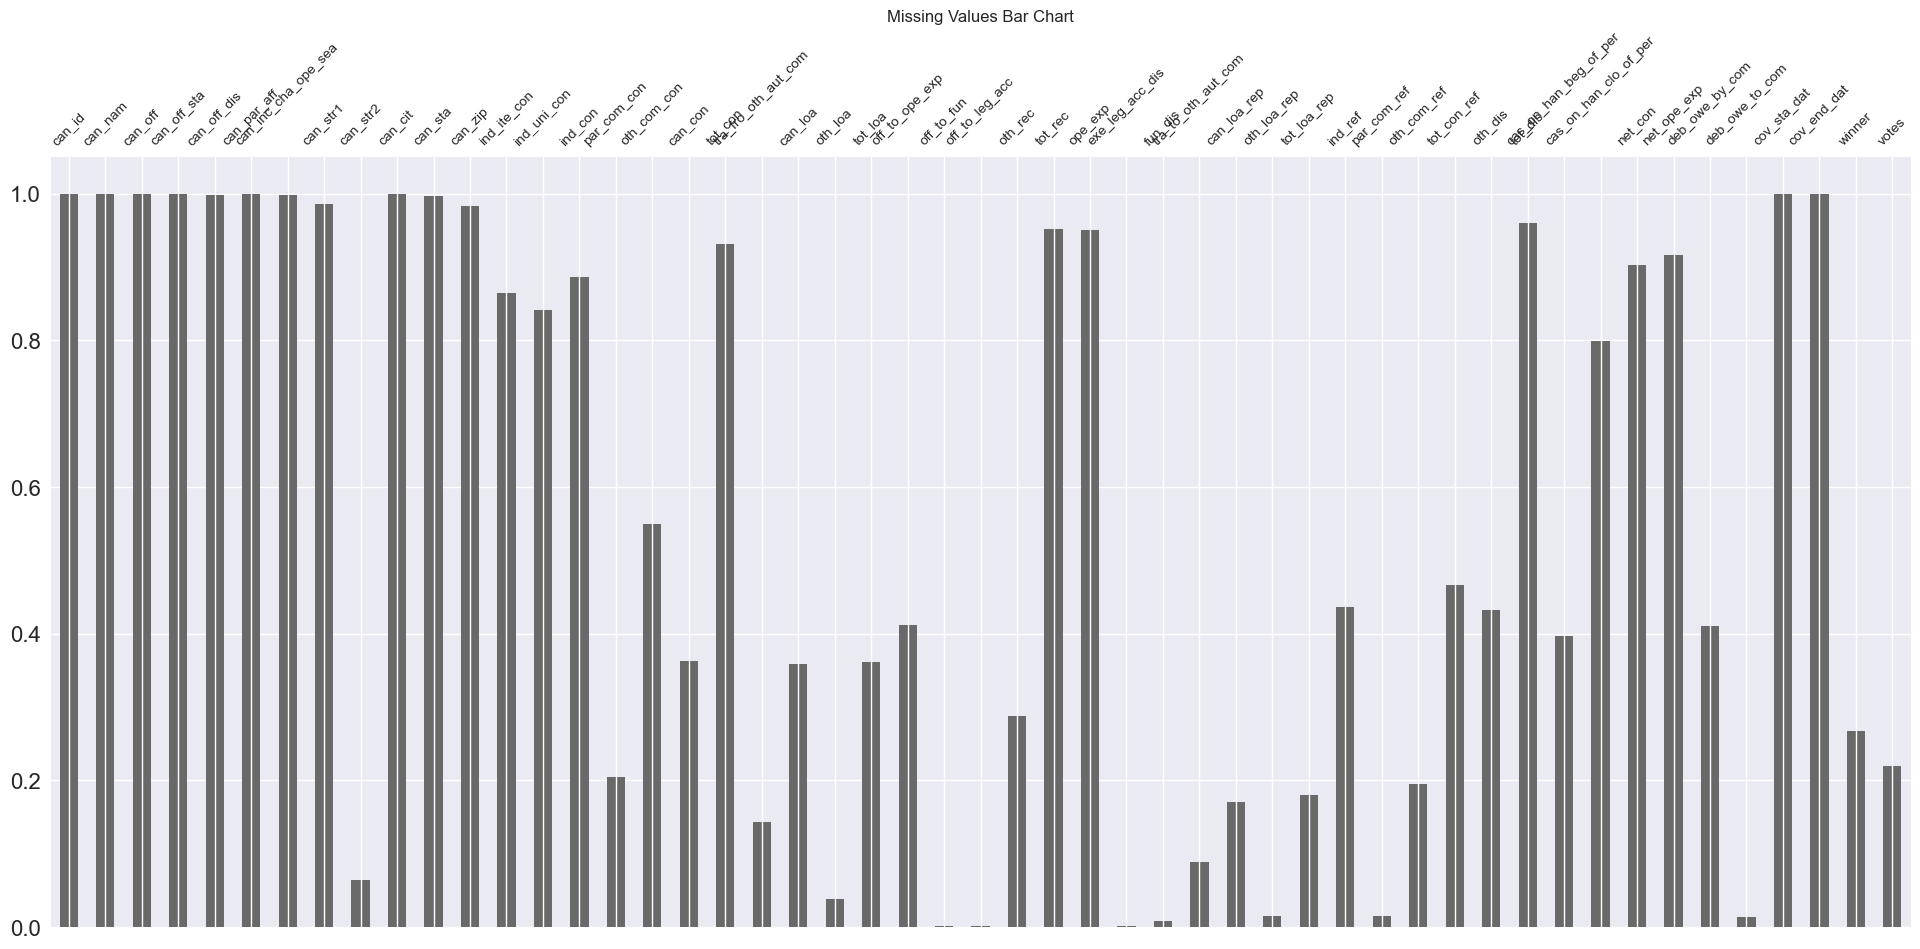

In [4]:

try: 
    msno.bar(df.sample(1000)) 
except ValueError: 
    pass

plt.title('Missing Values Bar Chart')
col_list = list(df.columns.values)
plt.xticks(ticks=[k for k in range(len(col_list))], labels=col_list, rotation=45);


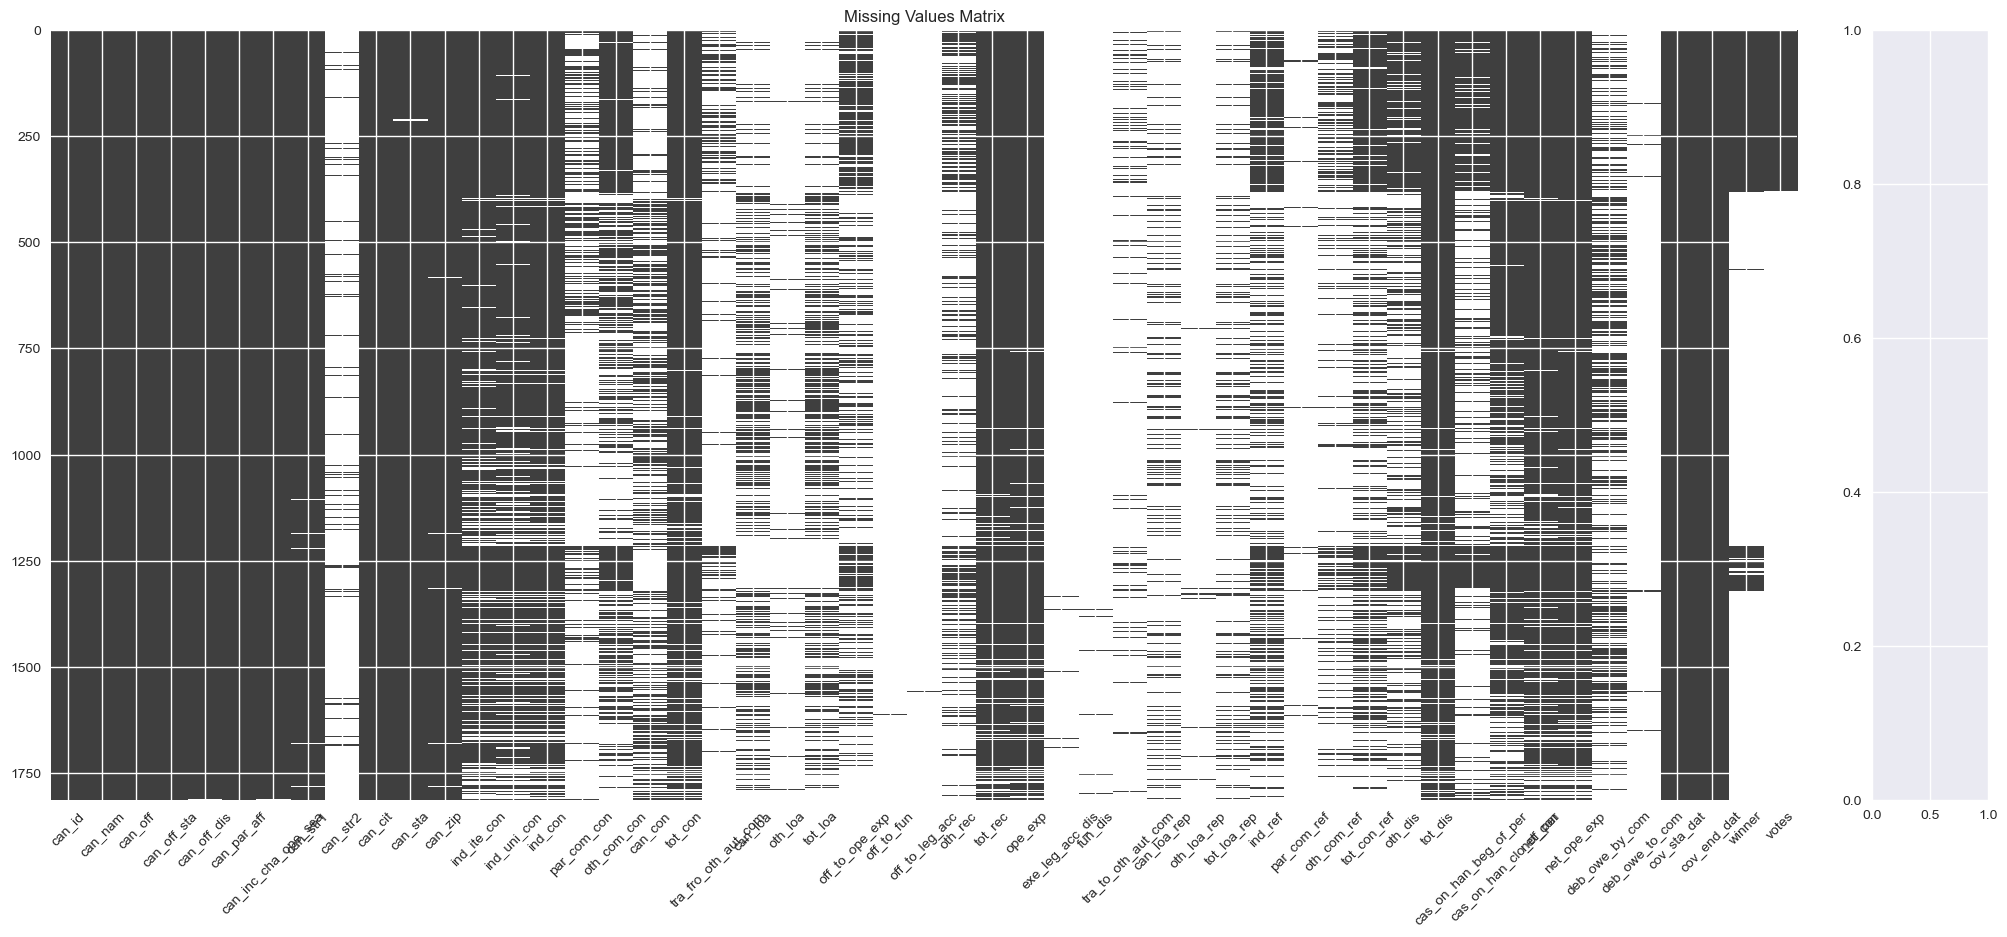

In [5]:

try:
    msno.matrix(df)
except ValueError:
    pass

plt.title('Missing Values Matrix')
col_list = list(df.columns.values)
plt.xticks(ticks=[k for k in range(len(col_list))], labels=col_list, rotation=45);


<Axes: >

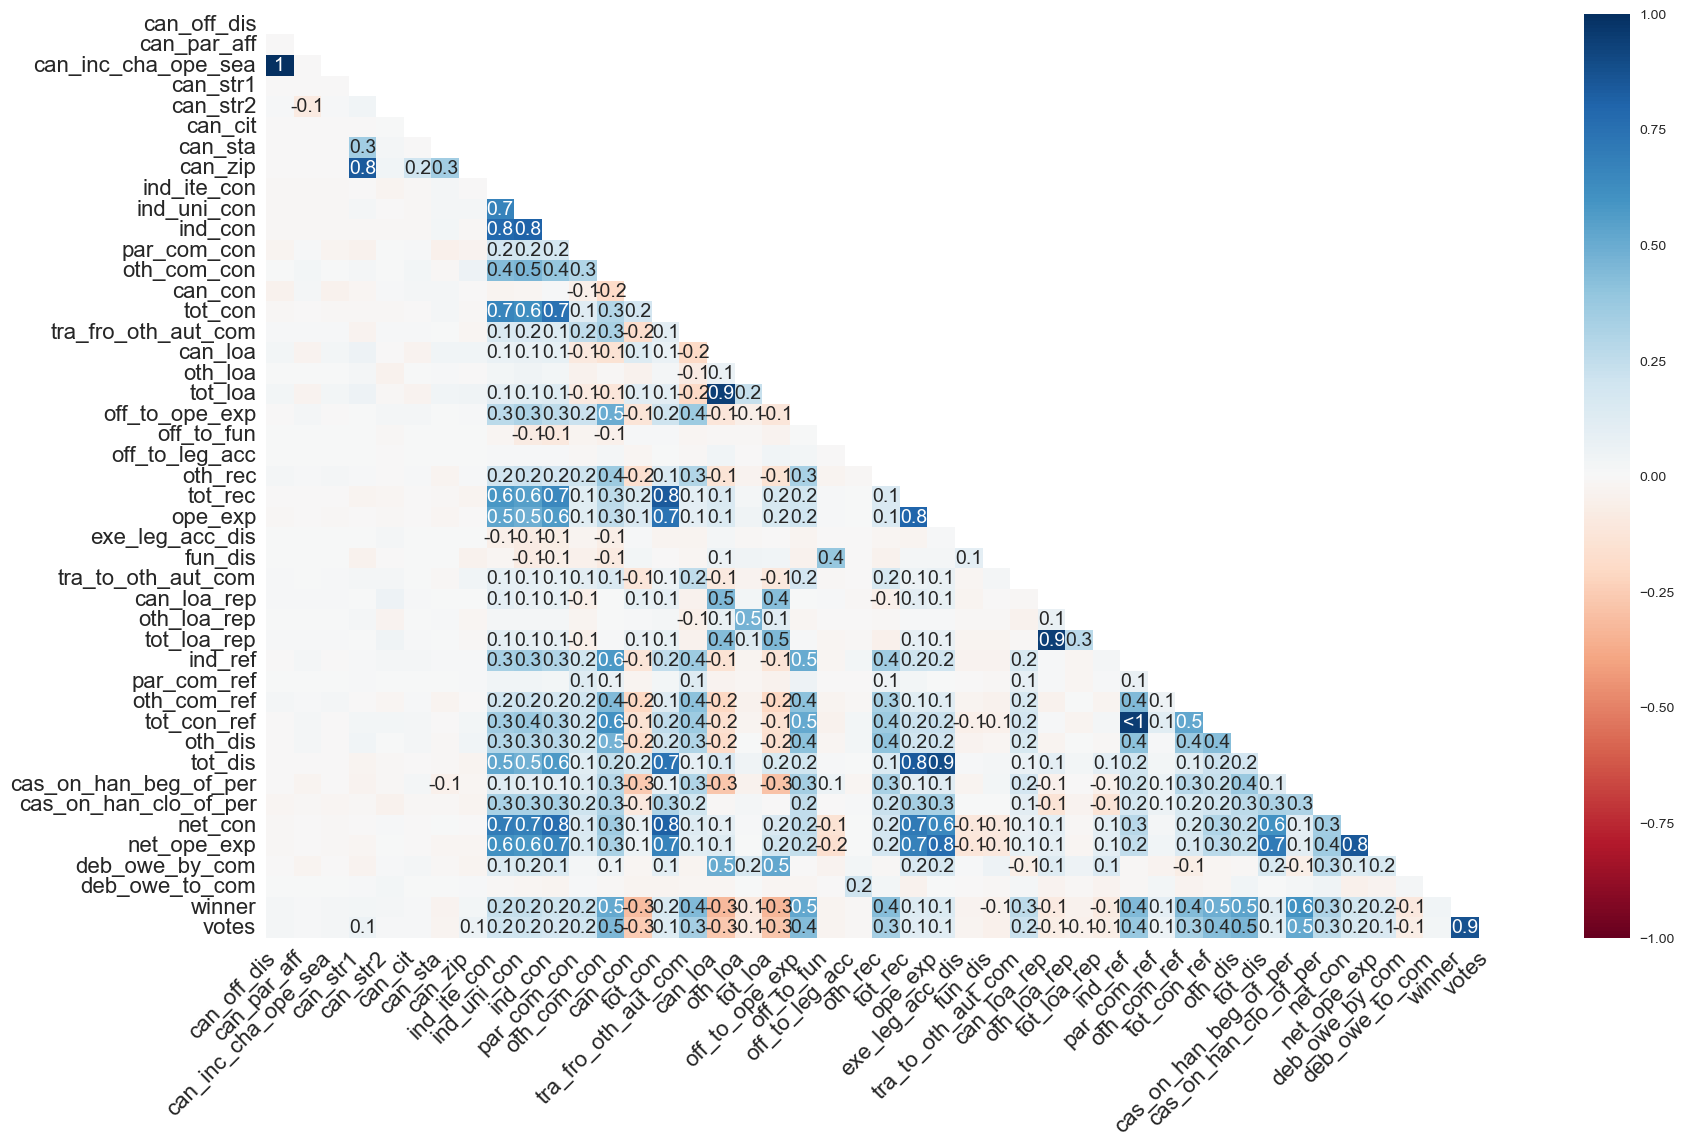

In [6]:

msno.heatmap(df)


In [97]:
# The foregoing check revealed a large amount of missing and extraneous data, to be dropped below, leaving only total 
# received campaign funds (converted from string to float), party affiliation (converted from string to int), competition,
# and election outcome (converted from string to int).

df['winner'] = df['winner'].map({'Y':1, np.nan:0})

comp_list = []

for k in range(0,len(df['can_off_dis'])):
    comp_list.append( len(df[df['can_off_dis']==df['can_off_dis'][k]]) )
    
df['comp'] = comp_list

map_dict = {'REP':'Republican', 'DEM':'Democrat', 'IND':'Independent'}
        
for p in [p for p in df['can_par_aff'].unique() if p not in ['REP','DEM','IND']]:
    map_dict[p] = 'Other'

df['can_par_aff'] = df['can_par_aff'].map(map_dict)

df['can_inc_cha_ope_sea'] = df['can_inc_cha_ope_sea'].map({'INCUMBENT':'Incumbent','CHALLENGER':'Challenger','OPEN':'Open'})
        
df.rename(columns={'can_par_aff':'party','can_inc_cha_ope_sea':'inc'}, inplace=True)  

indices = ['party', 'comp', 'inc', 'tot_rec', 'winner']
        
house = df[df['can_off']=='H'][indices]

house.dropna(inplace=True)

join_list = []
    
str_list = []

for c in house['tot_rec']:
    str_list = []
    for l in c:
        if l in ['0','1','2','3','4','5','6','7','8','9','.']:
            str_list.append(l)
    join_list.append(float(''.join(str_list)))

house['tot_rec'] = np.rint(join_list)


In [11]:
house.head()

,party,comp,inc,tot_rec,winner
0,Republican,34,Incumbent,1094023.0,1
1,Democrat,120,Challenger,1419271.0,1
2,Republican,100,Open,711288.0,1
3,Republican,428,Incumbent,5190888.0,1
4,Democrat,42,Incumbent,1209812.0,1


# II. Describing and Visualizing the Data


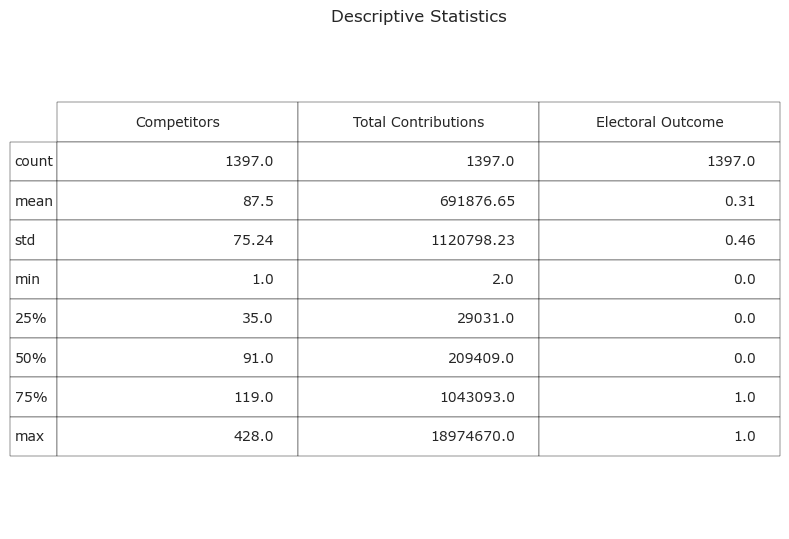

In [12]:

d = house.describe().round(2)

fig, ax = plt.subplots()

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=d.values.tolist(), rowLabels=d.index, colLabels=['Competitors','Total Contributions',
                                                                           'Electoral Outcome'], loc='center')
table.scale(1,2)
plt.title('Descriptive Statistics')

fig.tight_layout()


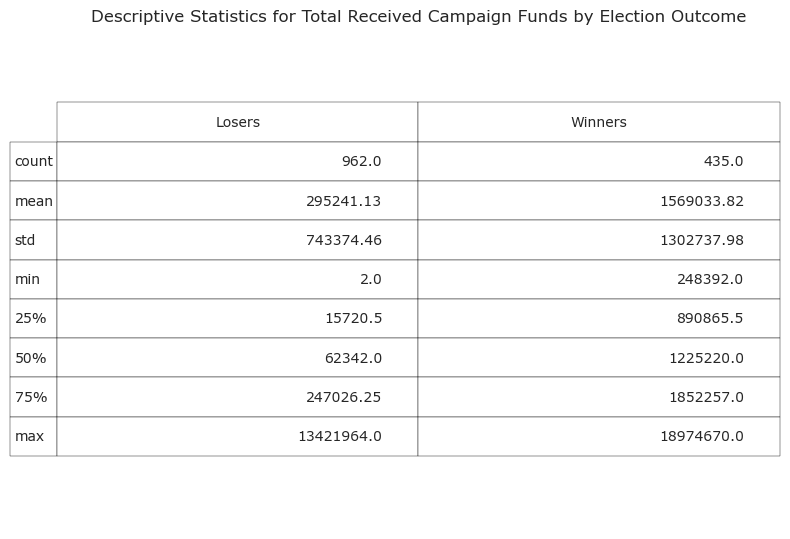

In [14]:

describe_losers = house[house['winner']==0].describe().round(2)

describe_winners = house[house['winner']==1].describe().round(2)

des = pd.concat([describe_losers['tot_rec'], describe_winners['tot_rec']], axis='columns')

fig, ax = plt.subplots()

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des.values.tolist(), rowLabels=des.index, colLabels=['Losers','Winners'], loc='center')
table.scale(1,2)
plt.title('Descriptive Statistics for Total Received Campaign Funds by Election Outcome')

fig.tight_layout()


Text(0, 0.5, 'Count')

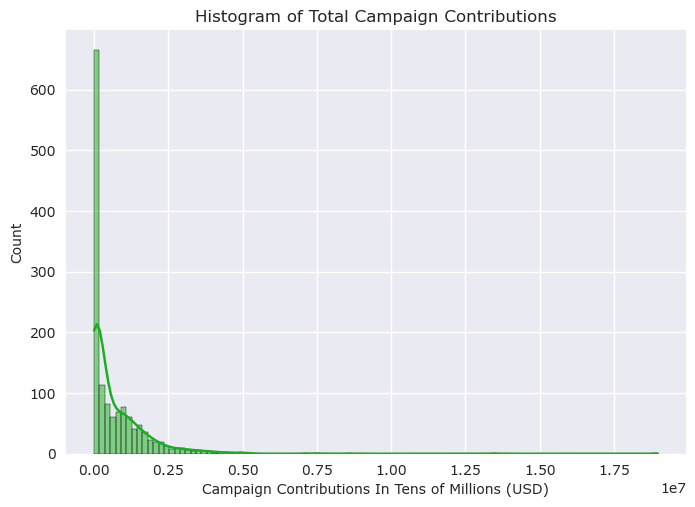

In [15]:

sns.histplot(data=house, x='tot_rec', kde=True, color='#15b01a')

plt.title('Histogram of Total Campaign Contributions')
plt.xlabel('Campaign Contributions In Tens of Millions (USD)')
plt.ylabel('Count')


Text(0, 0.5, 'Count')

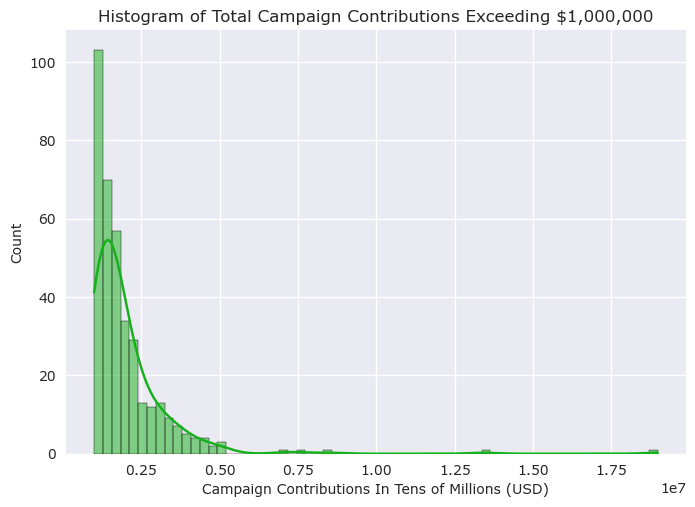

In [16]:

sns.histplot(data=house[house['tot_rec']>1000000], x='tot_rec', kde=True, color='#15b01a')

plt.title('Histogram of Total Campaign Contributions Exceeding $1,000,000')
plt.xlabel('Campaign Contributions In Tens of Millions (USD)')
plt.ylabel('Count')


([<matplotlib.axis.XTick at 0x26a393510c0>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

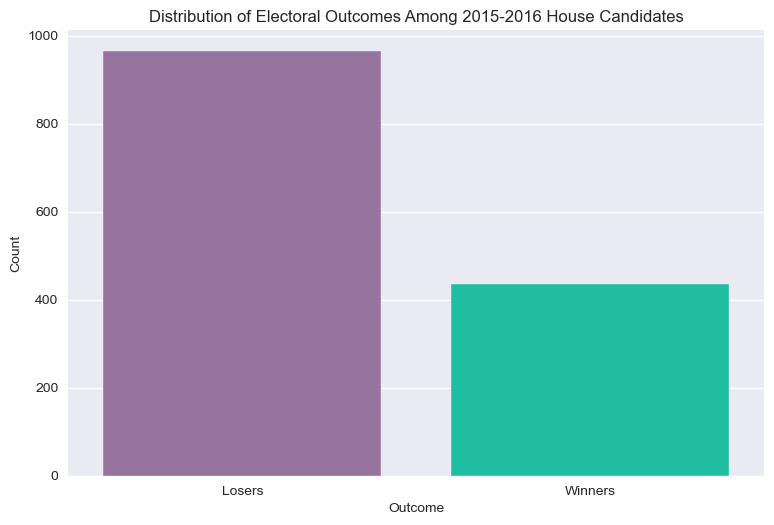

In [225]:

sns.countplot(data=house, x='winner', palette=['#9c6da5','#04d8b2'])

plt.title('Distribution of Electoral Outcomes Among 2015-2016 House Candidates')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])


([<matplotlib.axis.XTick at 0x1a48a82eb90>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

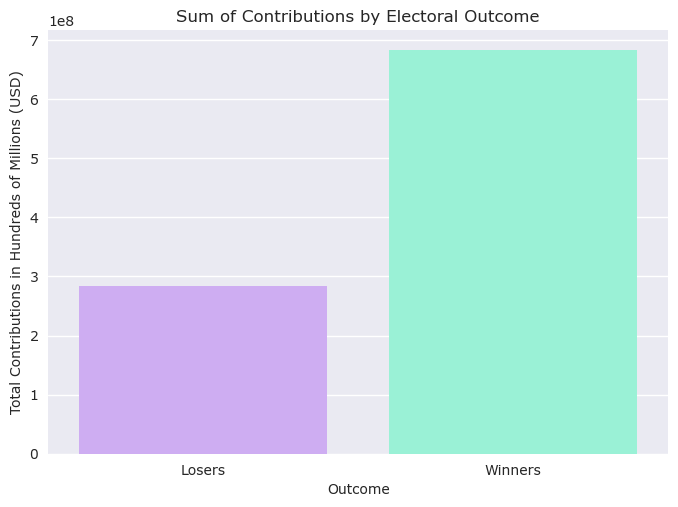

In [191]:

tot_rec_by_outcome = [house[house['winner']==0]['tot_rec'].sum(), house[house['winner']==1]['tot_rec'].sum()]

sns.barplot(x=[0,1], y=tot_rec_by_outcome, palette=['#cea2fd','#8cffdb'])

plt.title('Sum of Contributions by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Total Contributions in Hundreds of Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])


([<matplotlib.axis.XTick at 0x20520393e80>,
 [Text(0, 0, 'Loss'), Text(1, 0, 'Win')])

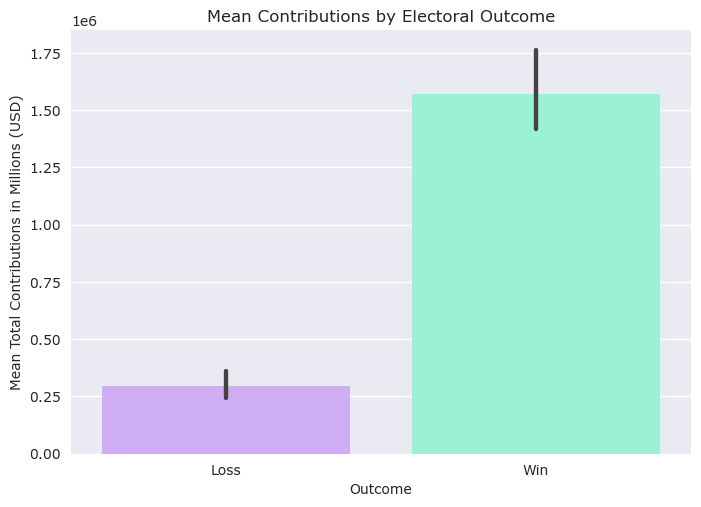

In [38]:

sns.barplot(data=house, x='winner', y='tot_rec', palette=['#cea2fd','#8cffdb'], errorbar=('ci',99))

plt.title('Mean Contributions by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Mean Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Loss','Win'])


([<matplotlib.axis.XTick at 0x205203ff310>,
 [Text(0, 0, 'Loss'), Text(1, 0, 'Win')])

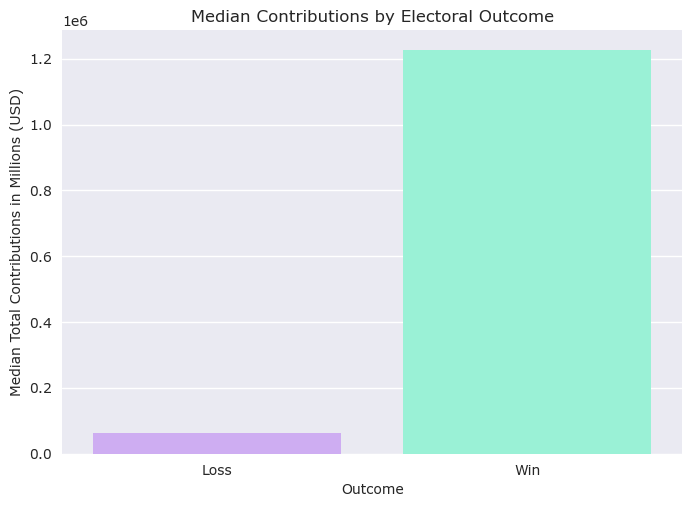

In [39]:

med_rec_by_outcome = [house[house['winner']==0]['tot_rec'].median(), house[house['winner']==1]['tot_rec'].median()]

sns.barplot(data=house, x=[0,1], y=med_rec_by_outcome, palette=['#cea2fd','#8cffdb'], errorbar=None)

plt.title('Median Contributions by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Median Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Loss','Win'])


([<matplotlib.axis.XTick at 0x213003ca4d0>,
 [Text(0, 0, 'Loss'), Text(1, 0, 'Win')])

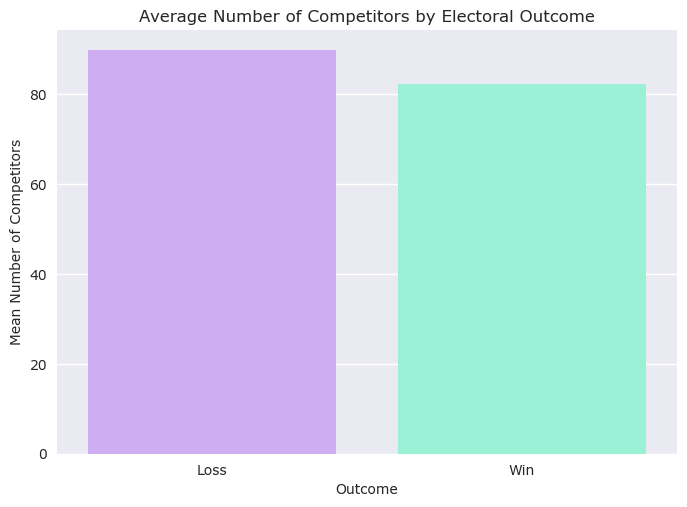

In [18]:

sns.barplot(data=house, x='winner', y='comp', palette=['#cea2fd','#8cffdb'], errorbar=None)

plt.title('Average Number of Competitors by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Mean Number of Competitors')
plt.xticks(ticks=[0,1], labels=['Loss','Win'])


([<matplotlib.axis.XTick at 0x21301323850>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

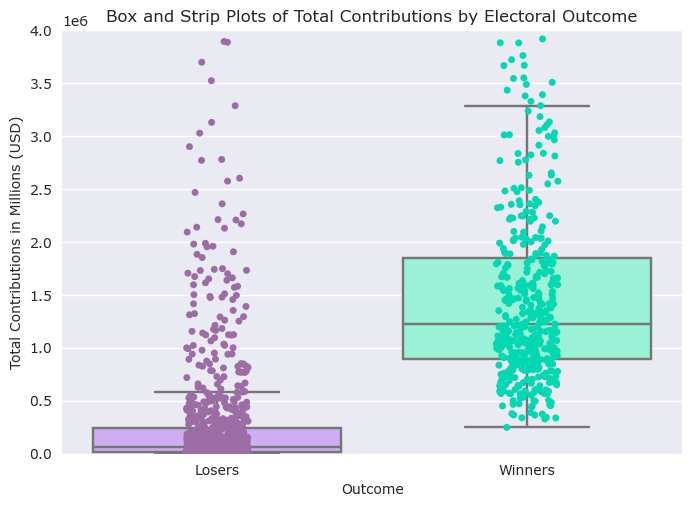

In [31]:

fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000)) 

ax = sns.boxplot(data=house, x='winner', y='tot_rec', showfliers=False, palette=['#cea2fd','#8cffdb'])

ax = sns.stripplot(data=house, x='winner', y='tot_rec', palette=['#9c6da5','#04d8b2'])

plt.title('Box and Strip Plots of Total Contributions by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])


## Focus on the Two Ruling Parties

In [183]:

duopoly = house.query("party in ['Democrat', 'Republican']")


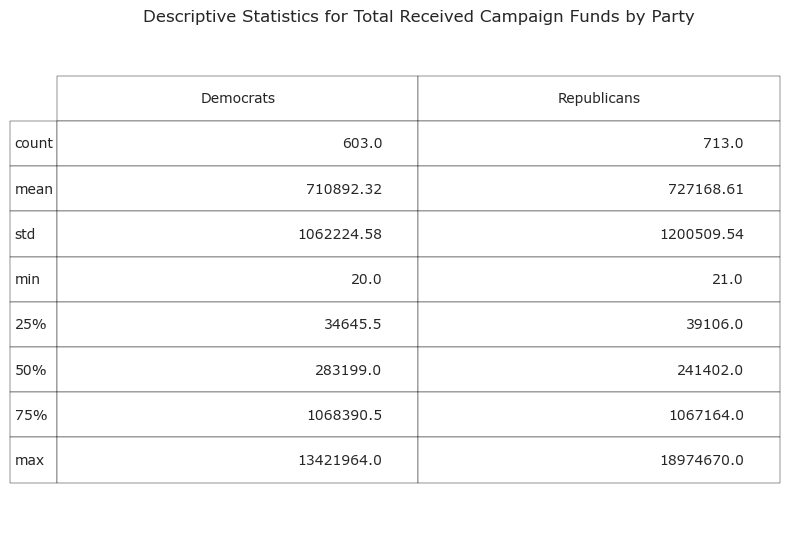

In [32]:

describe_dem = house[house['party']=='Democrat'].describe().round(2)

describe_rep = house[house['party']=='Republican'].describe().round(2)

des_party = pd.concat([describe_dem['tot_rec'], describe_rep['tot_rec']], axis='columns')

fig, ax = plt.subplots()

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=des_party.values.tolist(),rowLabels=des_party.index,colLabels=['Democrats','Republicans'],
                   loc='center')
table.scale(1,2.3)
plt.title('Descriptive Statistics for Total Received Campaign Funds by Party')

fig.tight_layout()


([<matplotlib.axis.XTick at 0x1a489de1360>,
 [Text(0, 0, 'Loss'), Text(1, 0, 'Win')])

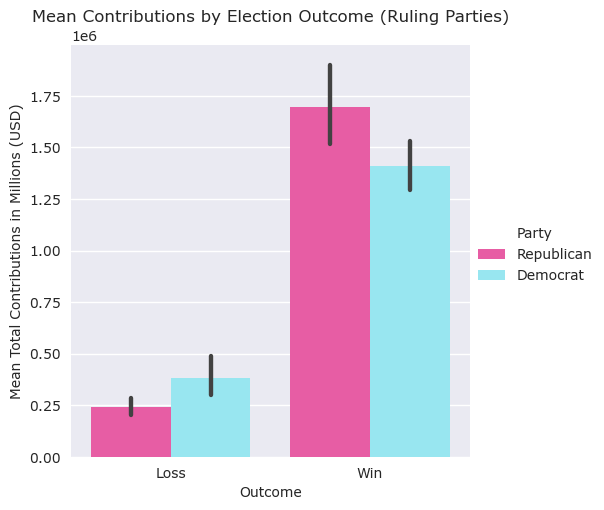

In [185]:

sns.catplot(data=duopoly, kind='bar', x='winner', y='tot_rec', hue='party', palette=['#fe46a5','#8af1fe'])

plt.title('Mean Contributions by Election Outcome (Ruling Parties)')
plt.xlabel('Outcome')
plt.ylabel('Mean Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Loss','Win'])


## Association of Incumbency with Contributions and Outcome

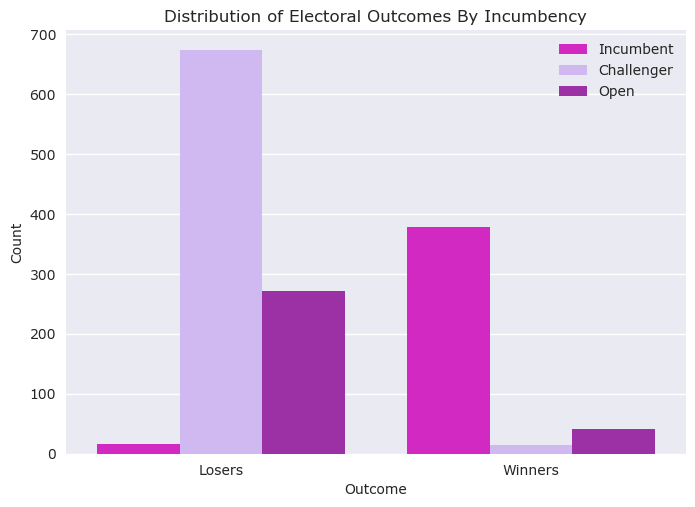

In [33]:

sns.countplot(data=house, x='winner', hue='inc', palette=['#ed0dd9', '#ceaefa', '#ac1db8'])

plt.title('Distribution of Electoral Outcomes By Incumbency')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])
plt.gca().legend().set_title('')


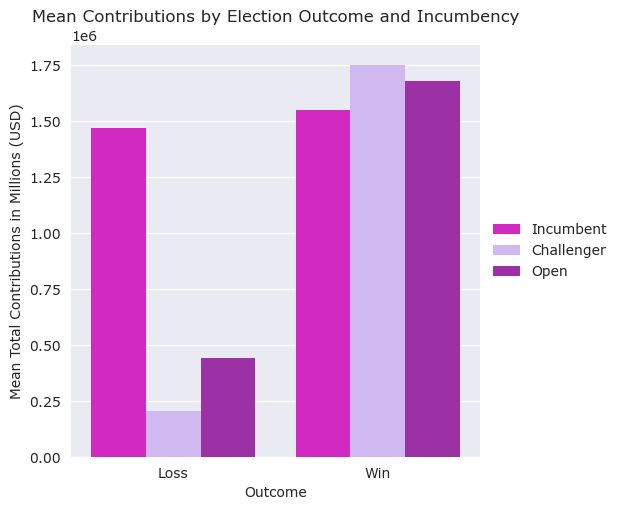

In [34]:

sns.catplot(data=house, kind='bar', x='winner', y='tot_rec', hue='inc', errorbar=None, 
            palette=['#ed0dd9', '#ceaefa', '#ac1db8'], legend=False)

plt.title('Mean Contributions by Election Outcome and Incumbency')
plt.xlabel('Outcome')
plt.ylabel('Mean Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Loss','Win'])
plt.legend(title='', labels=['Incumbent','Challenger','Open'], loc='center left', bbox_to_anchor=(1, 0.5))


([<matplotlib.axis.XTick at 0x21301b3dc30>,
 [Text(0, 0, 'Incumbent'), Text(1, 0, 'Challenger'), Text(2, 0, 'Open')])

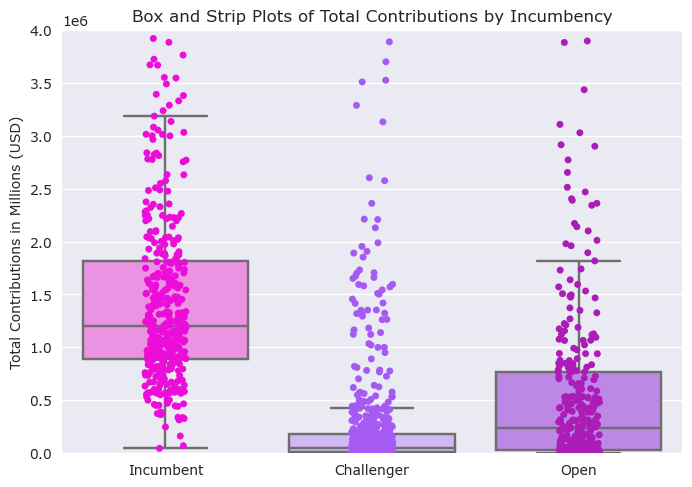

In [35]:

fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house, x='inc', y='tot_rec', showfliers=False, palette=['#f984ef', '#ceaefa', '#bf77f6'])

ax = sns.stripplot(data=house, x='inc', y='tot_rec', palette=['#ed0dd9', '#a55af4', '#ac1db8'])

plt.title('Box and Strip Plots of Total Contributions by Incumbency')
plt.xlabel('')
plt.ylabel('Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1,2], labels=['Incumbent','Challenger','Open'])


([<matplotlib.axis.XTick at 0x2130231da20>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

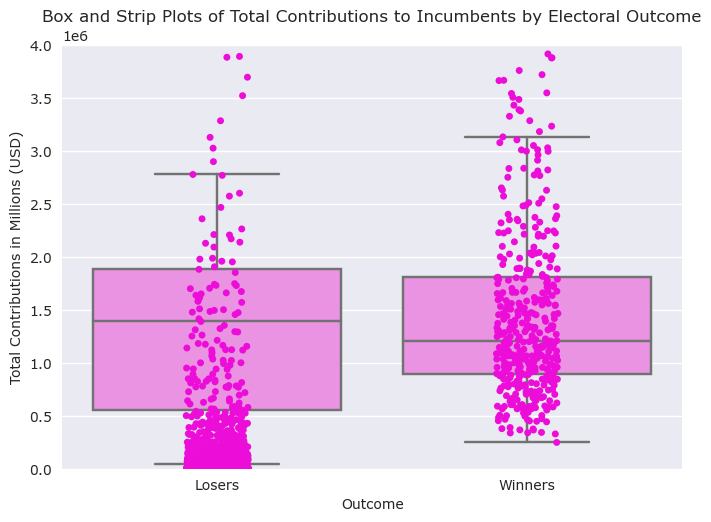

In [36]:

fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house[house['inc']=='Incumbent'], x='winner', y='tot_rec', showfliers=False, palette=['#f984ef'])

ax = sns.stripplot(data=house, x='winner', y='tot_rec', palette=['#ed0dd9'])

plt.title('Box and Strip Plots of Total Contributions to Incumbents by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])


([<matplotlib.axis.XTick at 0x213023b2da0>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

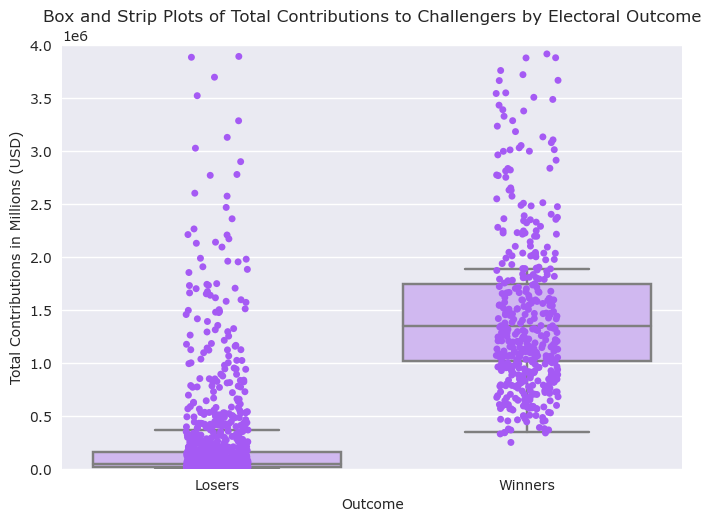

In [37]:

fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house[house['inc']=='Challenger'], x='winner', y='tot_rec', showfliers=False, palette=['#ceaefa'])

ax = sns.stripplot(data=house, x='winner', y='tot_rec', palette=['#a55af4'])

plt.title('Box and Strip Plots of Total Contributions to Challengers by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])



([<matplotlib.axis.XTick at 0x21302156da0>,
 [Text(0, 0, 'Losers'), Text(1, 0, 'Winners')])

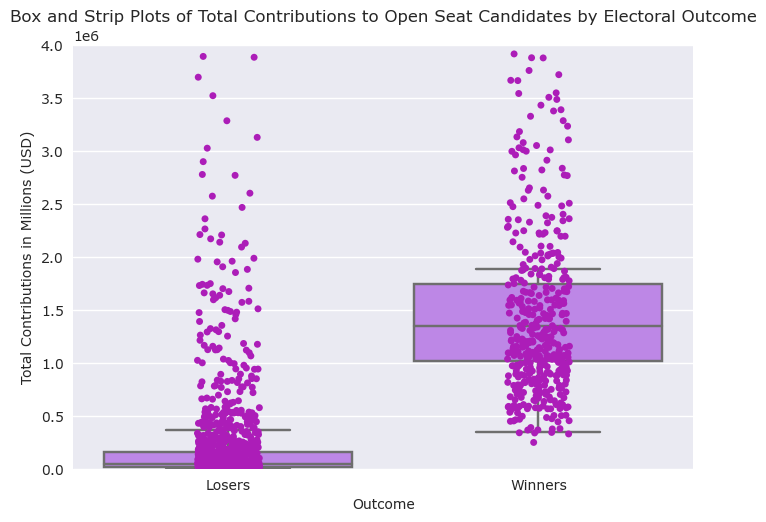

In [38]:

fig, ax = plt.subplots()

# Plot restricted to exclude 18 outliers (constituting approximately 1.3% of the dataset) exceeding $4,000,000 to produce 
# a more informative display
ax.set(ylim=(0, 4000000))

ax = sns.boxplot(data=house[house['inc']=='Challenger'], x='winner', y='tot_rec', showfliers=False, palette=['#bf77f6'])

ax = sns.stripplot(data=house, x='winner', y='tot_rec', palette=['#ac1db8'])

plt.title('Box and Strip Plots of Total Contributions to Open Seat Candidates by Electoral Outcome')
plt.xlabel('Outcome')
plt.ylabel('Total Contributions in Millions (USD)')
plt.xticks(ticks=[0,1], labels=['Losers','Winners'])


# III. Analyzing the Data

In [45]:

lose_rec = house[house['winner']==0]['tot_rec']

win_rec = house[house['winner']==1]['tot_rec']



## Check for Normality and Homoskedasticity 


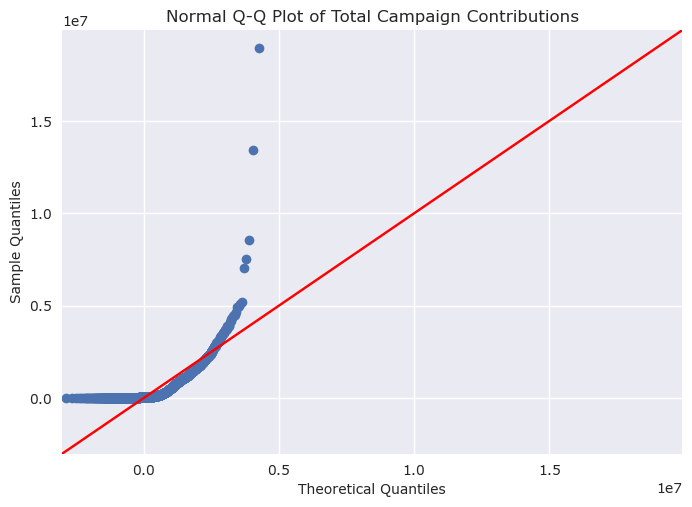

In [43]:


pp = sm.ProbPlot(house['tot_rec'], loc=np.mean(house['tot_rec']), scale=np.std(house['tot_rec']))

ax = pp.qqplot(line='45')

plt.title('Normal Q-Q Plot of Total Campaign Contributions')

plt.show()


In [46]:

shapiro_wilk = list(map(str, list(stats.shapiro(house['tot_rec']))))

kolmogorov_smirnov = list(map(str, list(stats.kstest(house['tot_rec'], 'norm'))))

levene = list(map(str, list(stats.levene(lose_rec, win_rec, center='mean'))))

brown_forsythe = list(map(str, list(stats.levene(lose_rec, win_rec, center='median'))))


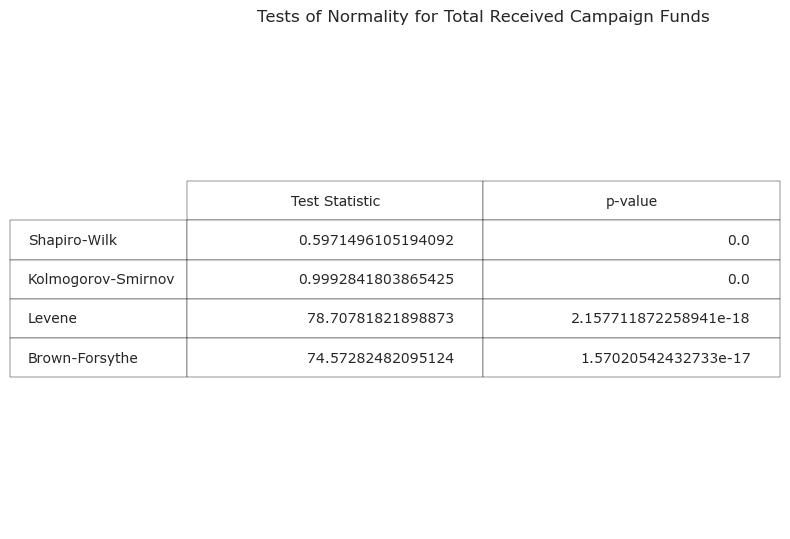

In [73]:

tests = [shapiro_wilk, kolmogorov_smirnov, levene, brown_forsythe] 

test_names = ['Shapiro-Wilk','Kolmogorov-Smirnov', 'Levene','Brown-Forsythe']

fig, ax = plt.subplots()

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=tests, colLabels=['Test Statistic','p-value'], rowLabels=test_names, loc='center')
table.scale(1,2)
plt.title('Tests of Normality for Total Received Campaign Funds')

fig.tight_layout()


## Correlational Analysis and Non-Parametric Comparison Testing

In [74]:

pearson = list(map(str, list(stats.pearsonr(house['tot_rec'],house['winner']))))

spearman = list(map(str, list(stats.spearmanr(house['tot_rec'],house['winner']))))

kendall = list(map(str, list(stats.kendalltau(house['tot_rec'],house['winner']))))

def statistic(x, y, axis):
    return np.median(x, axis=axis) - np.median(y, axis=axis)

pt = stats.permutation_test([win_rec, lose_rec], statistic)

perm = [pt.statistic, pt.pvalue]

mood = list(map(str, list(stats.median_test(lose_rec, win_rec))))[0:2]

mann_whitney = list(map(str, list(stats.mannwhitneyu(lose_rec, win_rec))))
               
kruskal_wallis = list(map(str, list(stats.kruskal(lose_rec,win_rec))))


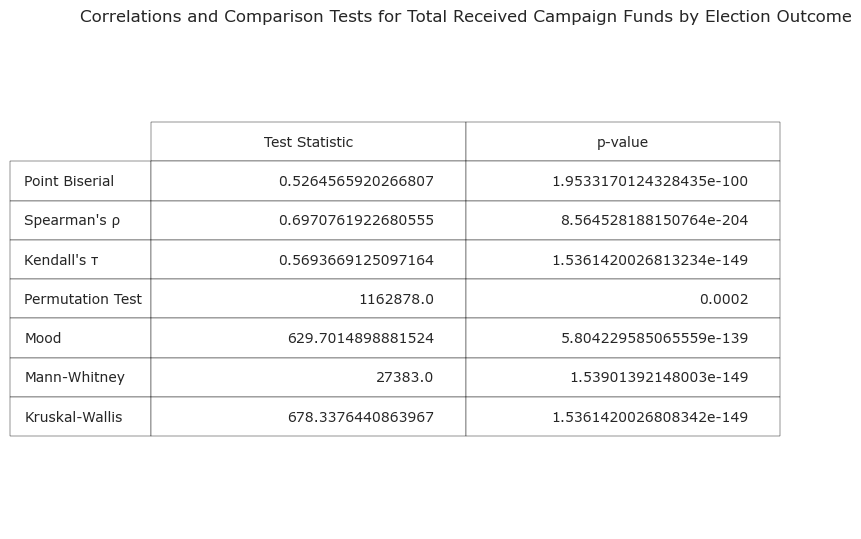

In [77]:

tests = [pearson, spearman, kendall, perm, mood, mann_whitney, kruskal_wallis]

test_names = ["Point Biserial", "Spearman's ρ", "Kendall's τ", 'Permutation Test', 'Mood', 'Mann-Whitney','Kruskal-Wallis']

fig, ax = plt.subplots()

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=tests, colLabels=['Test Statistic','p-value'], rowLabels=test_names, loc='center')
table.scale(1,2)
plt.title('Correlations and Comparison Tests for Total Received Campaign Funds by Election Outcome')
fig.tight_layout()


## Sample Proportions and Tests of Independence

### Proportion of Wins by Incumbency

In [78]:
h_inc = house[house['inc']=='Incumbent']

h_chal = house[house['inc']=='Challenger']
               
h_open = house[house['inc']=='Open']

p_inc = np.shape(h_inc[h_inc['winner']==1])[0] / np.shape(h_inc)[0]

p_chal = np.shape(h_chal[h_chal['winner']==1])[0] / np.shape(h_chal)[0]

p_open = np.shape(h_open[h_open['winner']==1])[0] / np.shape(h_open)[0]

p_inc, p_chal, p_open

(0.9570707070707071, 0.02180232558139535, 0.13099041533546327)

### Proportion of Wins by Incumbency Among All Candidates

In [79]:

h_inc = house[house['inc']=='Incumbent']

h_chal = house[house['inc']=='Challenger']
               
h_open = house[house['inc']=='Open']

p_inc = np.shape(h_inc[h_inc['winner']==1])[0] / np.shape(house)[0]

p_chal = np.shape(h_chal[h_chal['winner']==1])[0] / np.shape(house)[0]

p_open = np.shape(h_open[h_open['winner']==1])[0] / np.shape(house)[0]

p_inc, p_chal, p_open


(0.2712956335003579, 0.010737294201861132, 0.02934860415175376)

### Proportion of Wins by Incumbency Among All Winners

In [80]:

h_inc = house[house['inc']=='Incumbent']

h_chal = house[house['inc']=='Challenger']
               
h_open = house[house['inc']=='Open']

p_inc = np.shape(h_inc[h_inc['winner']==1])[0] / np.shape(house[house['winner']==1])[0]

p_chal = np.shape(h_chal[h_chal['winner']==1])[0] / np.shape(house[house['winner']==1])[0]

p_open = np.shape(h_open[h_open['winner']==1])[0] / np.shape(house[house['winner']==1])[0]

p_inc, p_chal, p_open


(0.871264367816092, 0.034482758620689655, 0.09425287356321839)

### Tests of Idependence

In [98]:

if type(house['winner'][0]) == int:
    house['winner'] = house['winner'].map({0:'Loss', 1:'Win'})


In [99]:

observed = pd.crosstab(index=house['inc'], columns=house['winner'])

observed


winner,0,1
inc,,
Challenger,673,15
Incumbent,17,379
Open,272,41


In [100]:

expected = pd.DataFrame(stats.chi2_contingency(observed).expected_freq, index=['Challenger','Incumbent','Open'],
             columns=['Loss','Win']).round().astype(int)

expected


,Loss,Win
Challenger,474,214
Incumbent,273,123
Open,216,97


In [101]:

chi2 = list(map(str, [stats.chi2_contingency(observed).statistic, stats.chi2_contingency(observed).pvalue]))


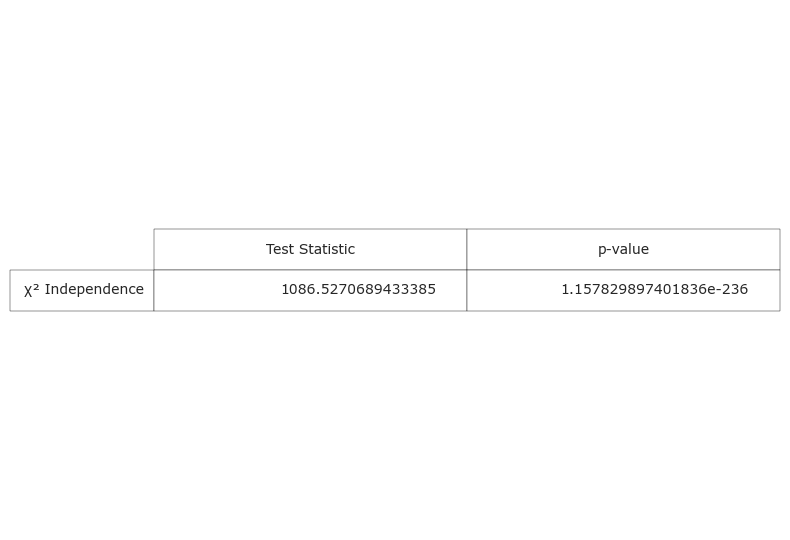

In [102]:

tests = [chi2]

test_names = ["χ² Independence"]

fig, ax = plt.subplots()

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=tests, colLabels=['Test Statistic','p-value'], rowLabels=test_names, loc='center')
table.scale(1,2)

fig.tight_layout()


In [103]:

if type(house['winner'][0]) == str:
    house['winner'] = house['winner'].map({'Loss':0, 'Win':1})


## One-Way ANCOVA of Trimmed and Transformed Data

### Ad Hoc Trim

In [105]:

# Counts the number of victories among those candidates with less than an arbitrary threshold amount in total campaign funds

house[house['tot_rec']<77000]['winner'].sum()


0

In [106]:

# It may be inferred from the fact that no candidate receiving less than $77,000 in total campaign contributions was elected
# that candidates receiving less than that amount are so unlikely to achieve victory as to effectively constitute 
# non-contenders. Accordingly, we exclude them from the following analysis.

lose_rec2 = house[house['winner']==0][house['tot_rec']>=77000]['tot_rec']

win_rec2 = house[house['winner']==1][house['tot_rec']>=77000]['tot_rec']

stats.percentileofscore(lose_rec,77000)


54.78170478170478

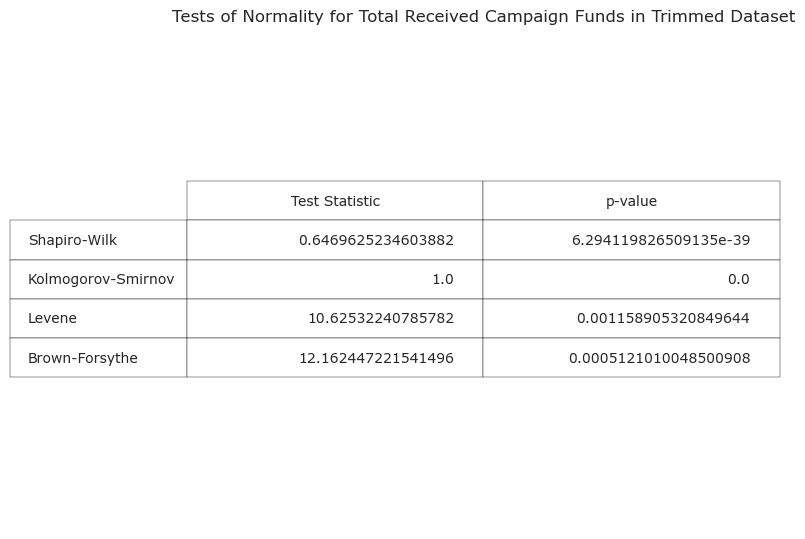

In [108]:

shapiro_wilk = list(map(str, list(stats.shapiro(house[house['tot_rec']>=77000]['tot_rec']))))

kolmogorov_smirnov = list(map(str, list(stats.kstest(house[house['tot_rec']>=77000]['tot_rec'], 'norm'))))

levene = list(map(str, list(stats.levene(lose_rec2, win_rec2, center='mean'))))

brown_forsythe = list(map(str, list(stats.levene(lose_rec2, win_rec2, center='median'))))

tests = [shapiro_wilk, kolmogorov_smirnov, levene, brown_forsythe] 

test_names = ['Shapiro-Wilk','Kolmogorov-Smirnov', 'Levene','Brown-Forsythe']

fig, ax = plt.subplots()

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=tests, colLabels=['Test Statistic','p-value'], rowLabels=test_names, loc='center')
table.scale(1,2)
plt.title('Tests of Normality for Total Received Campaign Funds in Trimmed Dataset')

fig.tight_layout()


In [109]:

house['inc'] = house['inc'].map({'Open':0,'Incumbent':1,'Challenger':2})

pg.ancova(data=house[house['tot_rec']>=77000], dv='tot_rec', covar='inc', between='winner')


,Source,SS,DF,F,p-unc,np2
0,winner,1.793031e+14,1,131.994302,1.548102e-28,0.132127
1,inc,4.148352e+12,1,3.053817,8.090163e-02,0.003510
2,Residual,1.177746e+15,867,NaN,NaN,NaN


In [110]:

house['inc'] = house['inc'].map({v:k for k,v in {'Open':0,'Incumbent':1,'Challenger':2}.items()})


### Outlier Trim

In [37]:

h = house[house['tot_rec']>np.quantile(house['tot_rec'], 0.4)]

q1 = np.quantile(h['tot_rec'], .25)

q3 = np.quantile(h['tot_rec'], .75)

iqr = stats.iqr(h['tot_rec'])
    
house_trim = h[house['tot_rec'] > q1 - 1.5 * iqr][house['tot_rec'] < q3 + 1.5 * iqr]
                     

In [38]:

lose_rec_trim = house_trim[house_trim['winner']==0]['tot_rec']

win_rec_trim = house_trim[house_trim['winner']==1]['tot_rec']


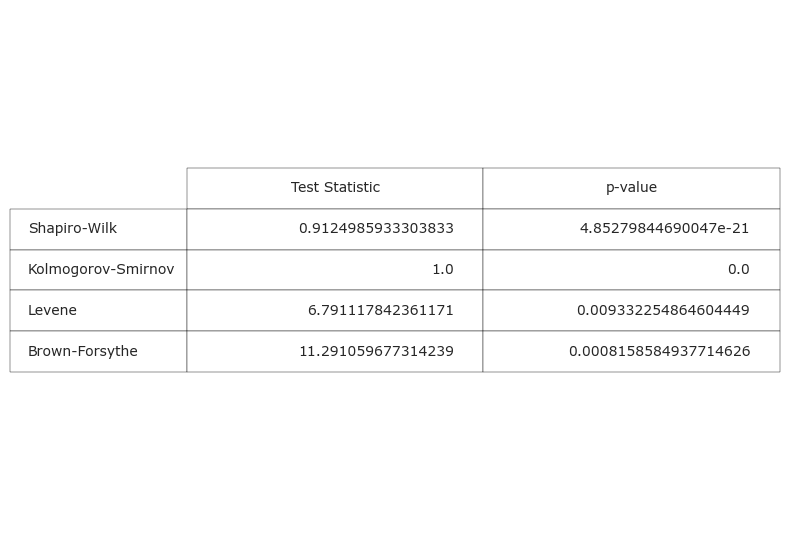

In [39]:

shapiro_wilk = list(map(str, list(stats.shapiro(house_trim['tot_rec']))))

kolmogorov_smirnov = list(map(str, list(stats.kstest(house_trim['tot_rec'], 'norm'))))

levene = list(map(str, list(stats.levene(lose_rec_trim, win_rec_trim, center='mean'))))

brown_forsythe = list(map(str, list(stats.levene(lose_rec_trim, win_rec_trim, center='median'))))

tests = [shapiro_wilk, kolmogorov_smirnov, levene, brown_forsythe] 

test_names = ['Shapiro-Wilk','Kolmogorov-Smirnov', 'Levene','Brown-Forsythe']

fig, ax = plt.subplots()

plt.rcParams['font.family'] = 'Verdana'
ax.axis('off'), ax.axis('tight')
table = ax.table(cellText=tests, colLabels=['Test Statistic','p-value'], rowLabels=test_names, loc='center')
table.scale(1,2)

fig.tight_layout()



In [40]:

house_trim['inc'] = house_trim['inc'].map({'Open':0,'Incumbent':1,'Challenger':2})

pg.ancova(data=house_trim, dv='tot_rec', covar='inc', between='winner')


,Source,SS,DF,F,p-unc,np2
0,winner,1.088888e+14,1,281.186772,2.838221e-54,0.261038
1,inc,1.628819e+12,1,4.206147,4.060462e-02,0.005256
2,Residual,3.082488e+14,796,NaN,NaN,NaN


In [41]:
house_trim['inc'] = house_trim['inc'].map({v:k for k,v in {'Open':0,'Incumbent':1,'Challenger':2}.items()})

## Assessment of Linear Separability with Single-Layer Perceptron

### Untransformed Data

In [113]:

from sklearn.linear_model import Perceptron

perceptron = Perceptron(random_state=137)

X = house[['inc','tot_rec']]

X = pd.get_dummies(X)

y = house['winner'].astype(int)

perceptron.fit(X, y)


Perceptron(random_state=137)

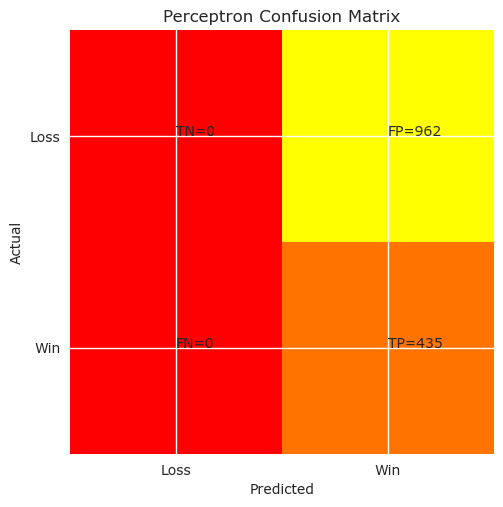

In [114]:

matrix = confusion_matrix(y, perceptron.predict(X))
 
plt.clf() 
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.autumn)

plt.title('Perceptron Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

target = ['Loss','Win']
ticks = [0,1]
plt.xticks(ticks, target)
plt.yticks(ticks, target)

labels = [['TN','FP'], ['FN', 'TP']]
  
for j in range(2):
    for k in range(2):
        plt.text(k,j, str(labels[j][k]) + '=' + str(matrix[j][k]))
        
plt.show()


### Rescaled Data

In [115]:

from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()

X_mm = minmax.fit_transform(X)


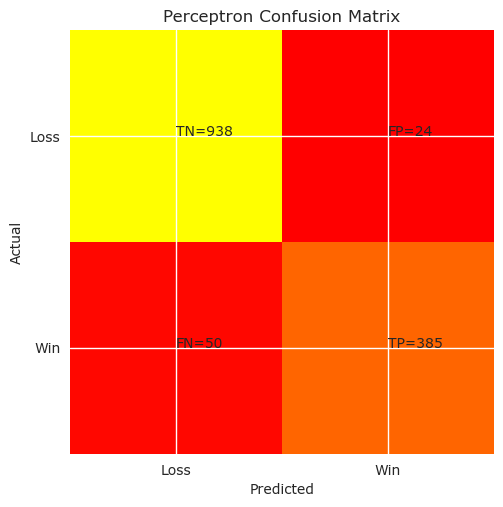

In [116]:

perceptron.fit(X_mm, y)

matrix = confusion_matrix(y, perceptron.predict(X_mm))

plt.clf() 
plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.autumn)

plt.title('Perceptron Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

target = ['Loss','Win']
ticks = [0,1]
plt.xticks(ticks, target)
plt.yticks(ticks, target)

labels = [['TN','FP'], ['FN', 'TP']]
  
for j in range(2):
    for k in range(2):
        plt.text(k,j, str(labels[j][k]) + '=' + str(matrix[j][k]))
        
plt.show()


# IV. Algorithmic Classification/Prediction (Bivariate)

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [ ]:

def optimizer(algorithm, param_grid, X, y):
    
    alg = algorithm
    
    gs = GridSearchCV(algorithm, param_grid).fit(X, y)
    
    alg_opt = alg.set_params(**gs.best_params_)
    
    return alg_opt


## Preprocessing

In [56]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = house[['inc','tot_rec']]

X = pd.get_dummies(X)

y = house['winner'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=137)

minmax = MinMaxScaler()

X_train_mm = minmax.fit_transform(X_train)

X_test_mm = minmax.transform(X_test)


## Logistic Regression

In [57]:

log_grid =  {'C':[0.001,0.01,0.1,1,5,7.5,10], 'class_weight':[None,'balanced'], 'penalty':['l1','l2']}

logreg = optimizer(LogisticRegression(), log_grid, X_train_mm, y_train)

logreg.fit(X_train_mm, y_train)

print(logreg.coef_, logreg.intercept_)


[[11.48892661 -2.63298272  3.74012112 -1.10726725]] [-0.49187806]


In [58]:

print(classification_report(logreg.predict(X_test_mm), y_test))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       311
           1       0.88      0.90      0.89       109

    accuracy                           0.94       420
   macro avg       0.92      0.93      0.93       420
weighted avg       0.94      0.94      0.94       420



Text(0.5, 1.0, 'Logistic Regression Confusion Matrix')

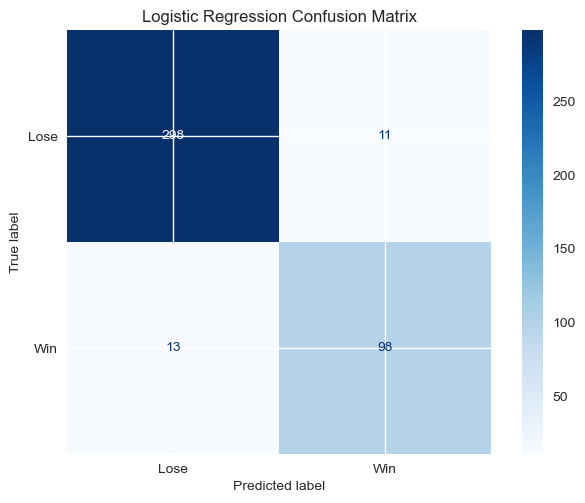

In [66]:

cm_logreg = confusion_matrix(y_test, logreg.predict(X_test_mm), labels=logreg.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=['Lose','Win']).plot(cmap=plt.cm.Blues)

plt.title('Logistic Regression Confusion Matrix')


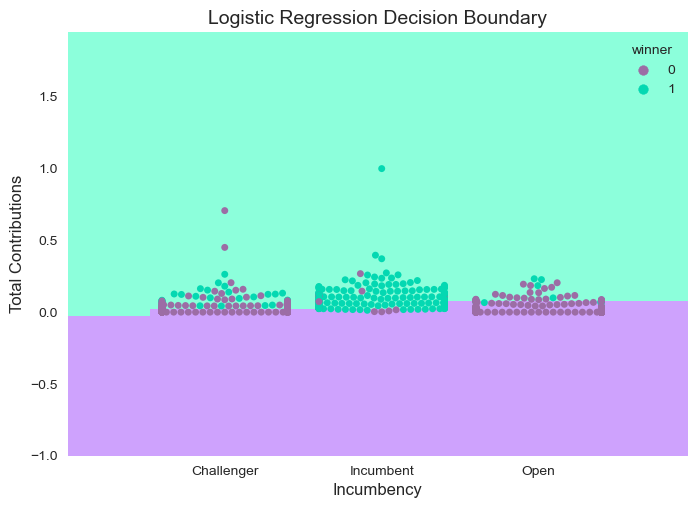

In [61]:

from matplotlib.colors import ListedColormap

H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = LogisticRegression(C=5, class_weight='balanced', penalty='l2')
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Logistic Regression Decision Boundary', fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)

plt.show()


## K-Nearest Neighbor

In [62]:

knn_grid = {'n_neighbors':range(1,100)}

knn = optimizer(KNeighborsClassifier(), knn_grid, X_train_mm, y_train)

knn.fit(X_train_mm, y_train)


KNeighborsClassifier(n_neighbors=25)

In [64]:

print(classification_report(y_test, knn.predict(X_test_mm)))


              precision    recall  f1-score   support

           0       0.97      0.96      0.96       309
           1       0.89      0.91      0.90       111

    accuracy                           0.95       420
   macro avg       0.93      0.94      0.93       420
weighted avg       0.95      0.95      0.95       420



Text(0.5, 1.0, 'k-NN Confusion Matrix')

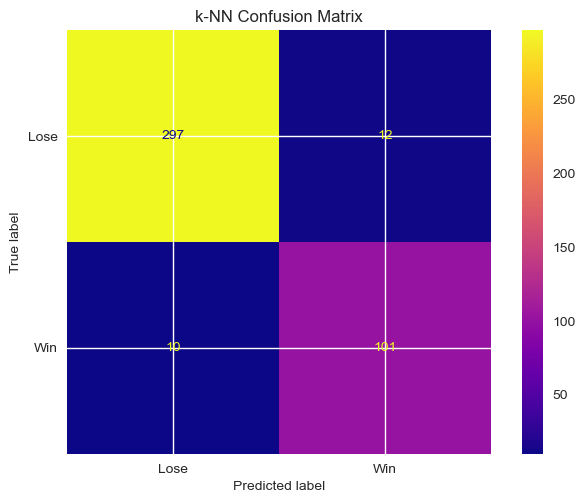

In [65]:


cm_knn = confusion_matrix(y_test, knn.predict(X_test_mm), labels=knn.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Lose','Win']).plot(cmap=plt.cm.plasma)

plt.title('k-NN Confusion Matrix')


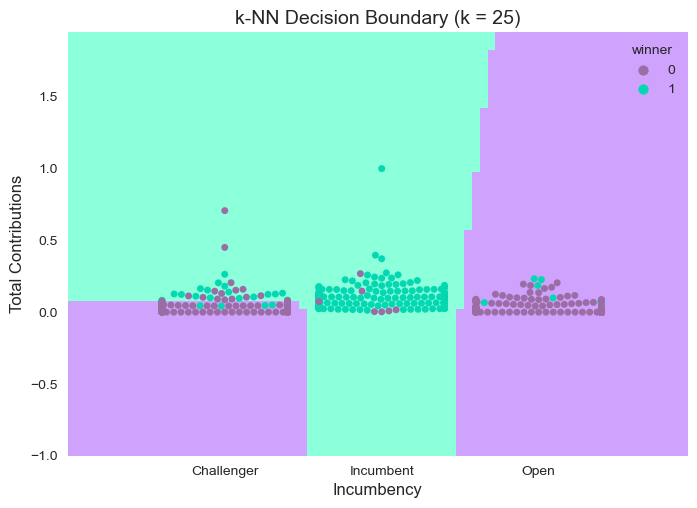

In [80]:

from matplotlib.colors import ListedColormap

H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

opt_k = knn.get_params()['n_neighbors']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = KNeighborsClassifier(n_neighbors=opt_k)
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("k-NN Decision Boundary (k = {})".format(str(opt_k)), fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)

plt.show()

## Support Vector Machine

In [76]:

svc_grid = {'C':[0.01,0.1,0.25,0.5,0.75,1], 'kernel':['libear','rbf', 'sigmoid'],
            'gamma':['scale','auto']}

svc = optimizer(SVC(), svc_grid, X_train_mm, y_train)

svc.fit(X_train_mm, y_train)


SVC(C=0.01)

In [77]:

print(classification_report(svc.predict(X_test_mm), y_test))


              precision    recall  f1-score   support

           0       0.97      0.96      0.97       314
           1       0.88      0.92      0.90       106

    accuracy                           0.95       420
   macro avg       0.93      0.94      0.93       420
weighted avg       0.95      0.95      0.95       420



Text(0.5, 1.0, 'SVC Confusion Matrix')

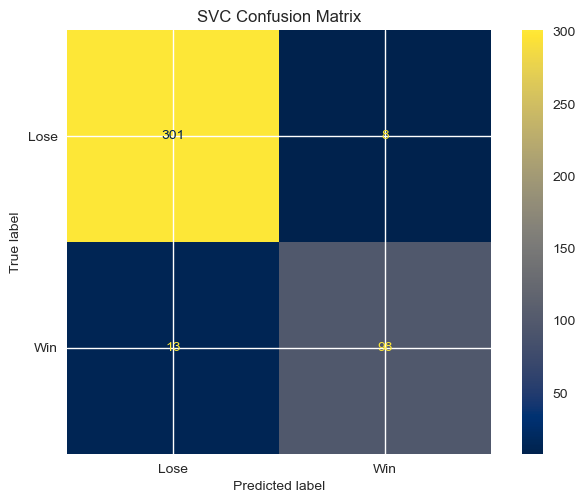

In [79]:

cm_svc = confusion_matrix(y_test, svc.predict(X_test_mm), labels=svc.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=['Lose','Win']).plot(cmap=plt.cm.cividis)

plt.title('SVC Confusion Matrix')


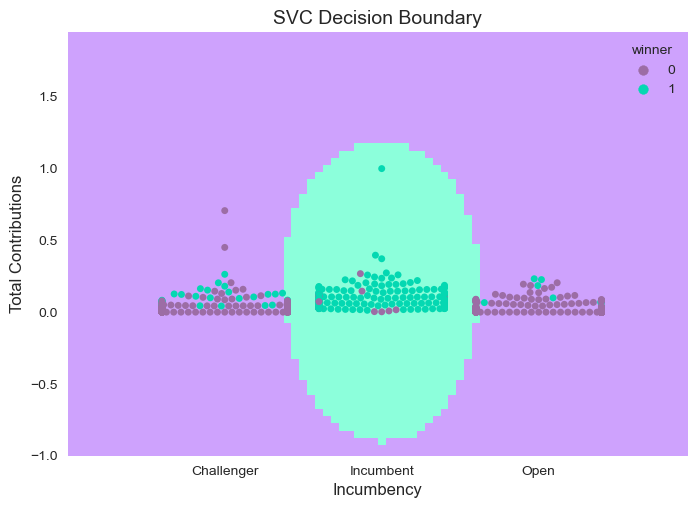

In [81]:

from matplotlib.colors import ListedColormap

H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = svc
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("SVC Decision Boundary", fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)

plt.show()


## Decision Tree

In [82]:

tree_grid = {'criterion':['gini','entropy','log_loss'], 'max_depth':range(2,10), 'ccp_alpha': [0.1,0.01,0.001,0]}

tree = optimizer(DecisionTreeClassifier(), tree_grid, X_train_mm, y_train)

tree.fit(X_train_mm, y_train)


DecisionTreeClassifier(ccp_alpha=0.1, max_depth=2)

In [84]:

print(classification_report(tree.predict(X_test_mm), y_test))


              precision    recall  f1-score   support

           0       0.97      0.96      0.97       314
           1       0.88      0.92      0.90       106

    accuracy                           0.95       420
   macro avg       0.93      0.94      0.93       420
weighted avg       0.95      0.95      0.95       420



Text(0.5, 1.0, 'Decision Tree Confusion Matrix')

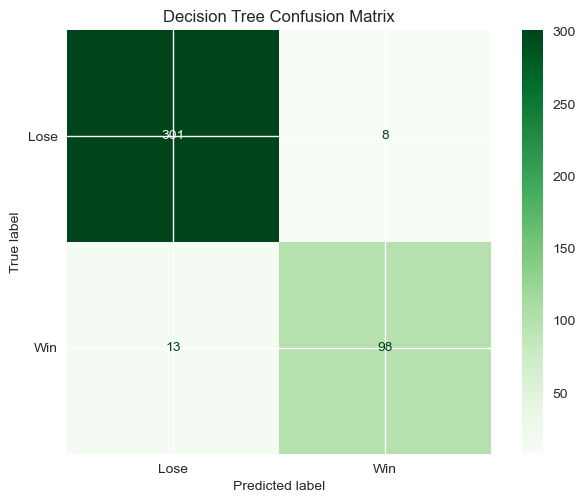

In [87]:

cm_tree = confusion_matrix(y_test, tree.predict(X_test_mm), labels=tree.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=['Lose','Win']).plot(cmap=plt.cm.Greens)

plt.title('Decision Tree Confusion Matrix')


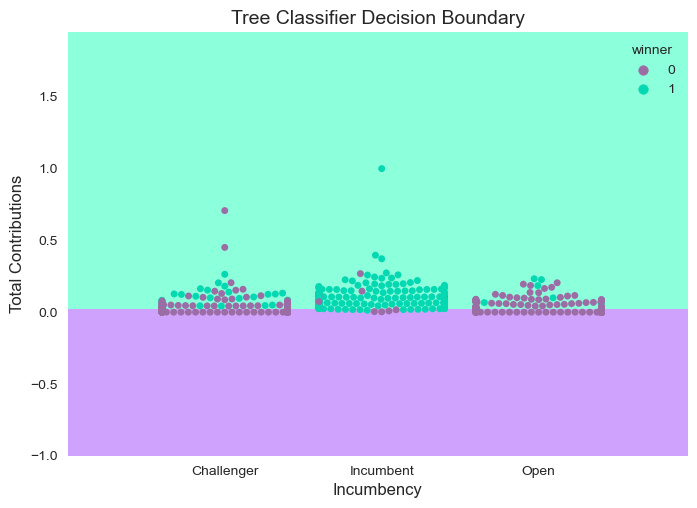

In [96]:

from matplotlib.colors import ListedColormap

H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = tree
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("Tree Classifier Decision Boundary", fontsize=14)
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency', fontsize=12)
plt.ylabel('Total Contributions', fontsize=12)

plt.show()


## Multilayer Perceptron

In [90]:

mlp_grid = {'hidden_layer_sizes':[(j,j,j) for j in range(10,30,10)], 'activation':['indentity','logistic','tanh','relu'], 
        'solver':['lbfgs','sgd','adam']}

mlp = optimizer(MLPClassifier(random_state=137), mlp_grid, X_train_mm, y_train)

mlp.fit(X_train_mm, y_train)


MLPClassifier(activation='logistic', hidden_layer_sizes=(10, 10, 10),
              random_state=137, solver='lbfgs')

In [92]:

print(classification_report(mlp.predict(X_test_mm), y_test))

report_dict = classification_report(y_test, mlp.predict(X_test_mm), output_dict=True)
pd.DataFrame(report_dict).to_csv('C:/Users/Paul/Documents/STAT490/report.csv')


              precision    recall  f1-score   support

           0       0.95      0.98      0.97       298
           1       0.95      0.87      0.91       122

    accuracy                           0.95       420
   macro avg       0.95      0.93      0.94       420
weighted avg       0.95      0.95      0.95       420



Text(0.5, 1.0, 'Triple-Layer Perceptron Confusion Matrix')

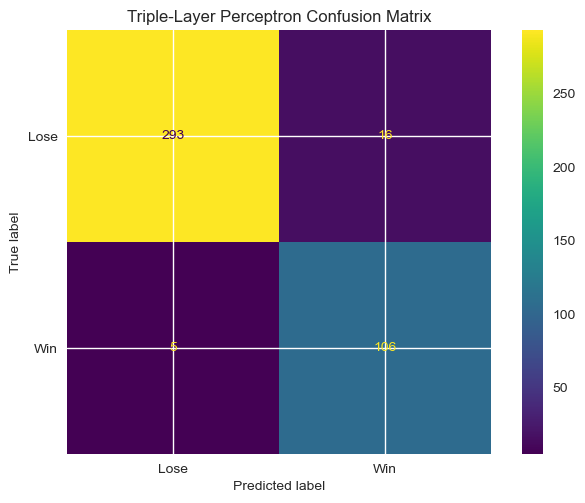

In [95]:

cm_mlp = confusion_matrix(y_test, mlp.predict(X_test_mm), labels=mlp.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=['Lose','Win']).plot(cmap=plt.cm.viridis)

plt.title('Triple-Layer Perceptron Confusion Matrix')


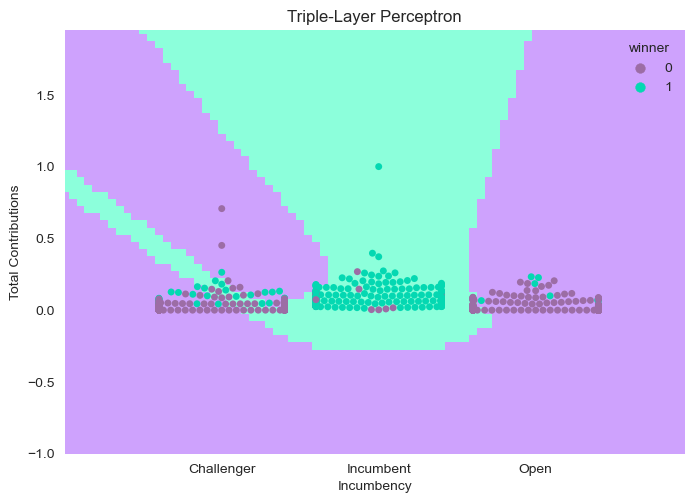

In [93]:


from matplotlib.colors import ListedColormap

H = house.copy(deep=True)

H['inc'] = H['inc'].map({'Incumbent':1,'Challenger':2,'Open':0})

H['tot_rec'] = ( H['tot_rec'] - min(H['tot_rec']) ) / ( max(H['tot_rec']) - min(H['tot_rec']) )

X = H[['inc','tot_rec']]

y = H['winner']

h = .05  

cmap_light = ListedColormap(['#cea2fd','#8cffdb'])
cmap_bold = ListedColormap(['#9c6da5','#04d8b2'])

clf = MLPClassifier(hidden_layer_sizes=(10,10,10), activation='logistic', solver='lbfgs', random_state=137)
clf.fit(X, y)

x_min, x_max = X['inc'].min() - 1, X['inc'].max() + 1
y_min, y_max = X['tot_rec'].min() - 1, X['tot_rec'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

sns.swarmplot(data=H, x='inc', y='tot_rec', hue='winner', palette=['#9c6da5','#04d8b2'])
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title('Triple-Layer Perceptron')
plt.xticks(ticks=[0,1,2], labels=['Challenger','Incumbent','Open'])
plt.xlabel('Incumbency')
plt.ylabel('Total Contributions')

plt.show()


# V. Algorithmic Classification (Trivariate)

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

## Preprocessing

In [36]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X = house[['inc','comp','tot_rec']]

X = pd.get_dummies(X)

y = house['winner'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=137)

minmax = MinMaxScaler()

X_train_mm = minmax.fit_transform(X_train)

X_test_mm = minmax.transform(X_test)


In [45]:

def optimizer(algorithm, param_grid, X, y):
    
    alg = algorithm
    
    gs = GridSearchCV(algorithm, param_grid).fit(X, y)
    
    alg_opt = alg.set_params(**gs.best_params_)
    
    return alg_opt


## Logistic Regression

In [47]:

log_grid =  {'C':[0.001,0.01,0.1,1,5,7.5,10], 'class_weight':[None,'balanced'], 'penalty':['l1','l2']}

logreg = optimizer(LogisticRegression(), log_grid, X_train_mm, y_train)

logreg.fit(X_train_mm, y_train)

print(logreg.coef_, logreg.intercept_)


[[-0.62219446 11.38251456 -2.64739551  3.74312147 -1.09570777]] [-0.3584151]


In [48]:

print(classification_report(logreg.predict(X_test_mm), y_test))


              precision    recall  f1-score   support

           0       0.96      0.96      0.96       311
           1       0.88      0.90      0.89       109

    accuracy                           0.94       420
   macro avg       0.92      0.93      0.93       420
weighted avg       0.94      0.94      0.94       420



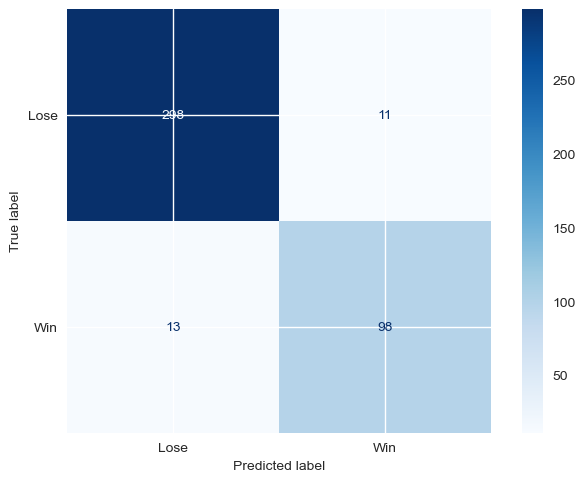

In [49]:

cm_logreg = confusion_matrix(y_test, logreg.predict(X_test_mm), labels=logreg.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=['Lose','Win']).plot(cmap=plt.cm.Blues)


## Decision Tree

In [51]:

tree_grid = {'criterion':['gini','entropy','log_loss'], 'max_depth':range(2,10), 'ccp_alpha': [0.1,0.01,0.001,0]}

tree = optimizer(DecisionTreeClassifier(), tree_grid, X_train_mm, y_train)

tree.fit(X_train_mm, y_train)


DecisionTreeClassifier(ccp_alpha=0.1, max_depth=2)

In [53]:

print(classification_report(tree.predict(X_test_mm), y_test))


              precision    recall  f1-score   support

           0       0.97      0.96      0.97       314
           1       0.88      0.92      0.90       106

    accuracy                           0.95       420
   macro avg       0.93      0.94      0.93       420
weighted avg       0.95      0.95      0.95       420



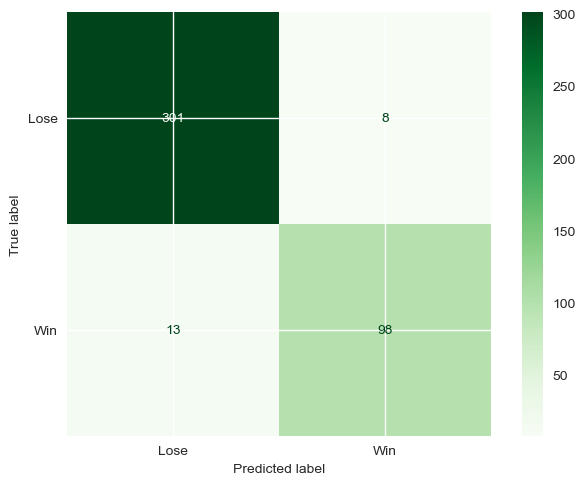

In [55]:

cm_tree = confusion_matrix(y_test, tree.predict(X_test_mm), labels=tree.classes_)

ConfusionMatrixDisplay(confusion_matrix=cm_tree, display_labels=['Lose','Win']).plot(cmap=plt.cm.Greens)
